In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import re

from tqdm import tqdm_notebook
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint

# 경고표시 지우기
import warnings
warnings.filterwarnings(action="ignore")

# matplotlib는 한글 폰트가 지원이 안됨. 지원되게하려면.
# import matplotlib.font_manager as fm
# font_name = fm.FontProperties(fname = "C:/Windows/Fonts/malgun.ttf").get_name() # 맑은고딕폰트이름

# 폰트를 지정해주는 작업
# plt.rc("font", family = font_name)

# 한글 폰트때문에 깨져보이는 -를 다시 보일 수 있게 해주는 작업
# import matplotlib as mpl
# mpl.rcParams["axes.unicode_minus"] = False

In [3]:
# From https://github.com/yoonkim/CNN_sentence/blob/master/process_data.py
def clean_str(string):    
    string = re.sub(r"[^가-힣A-Za-z0-9(),!?\'\`]", " ", string)
    string = re.sub(r"\'s", " \'s", string)
    string = re.sub(r"\'ve", " \'ve", string)
    string = re.sub(r"n\'t", " n\'t", string)
    string = re.sub(r"\'re", " \'re", string)
    string = re.sub(r"\'d", " \'d", string)
    string = re.sub(r"\'ll", " \'ll", string)
    string = re.sub(r",", " , ", string)
    string = re.sub(r"!", " ! ", string)
    string = re.sub(r"\(", " \( ", string)
    string = re.sub(r"\)", " \) ", string)
    string = re.sub(r"\?", " \? ", string)
    string = re.sub(r"\s{2,}", " ", string)
    string = re.sub(r"\'{2,}", "\'", string)
    string = re.sub(r"\'", "", string)

    return string.lower()

def lstm_model(vocab_size, embedding_dim, input_length):
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=input_length),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=64, return_sequences=True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=64)),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(16, activation='relu'),
        tf.keras.layers.Dense(6, activation='softmax')
    ])

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    print(model.summary())
    
    return model

['생크림이', '좀더', '듬뿍', '올라가고', ',', '시트가', '더', '부드러우면', '더', '맛있을거같다', '우유향이', '나고', '부드러운', '생크림', '신선하고', '새콤달콤한', '딸기', '드립커피도', '꽤', '괜찮은', '편', '양에', '비해', '비싸지만', '만족스러운', '딸기케이크였다']
['굿굿', '!', '']
['맛있어요']
['맛있어요']
['진짜', '유명해서', '한번', '먹어봄', '생딸기가', '아니고', '절임딸기', '한조각', '6300원', '시트도', '퍼석하고', '크림은', '그냥그럼', '이게', '맛있다는', '분들은', '생딸기를', '안드셔보셨거나', '생딸기를', '너무', '많이', '먹어서', '질려서', '맛있으신듯', '내', '돈', '내', '시간', '']


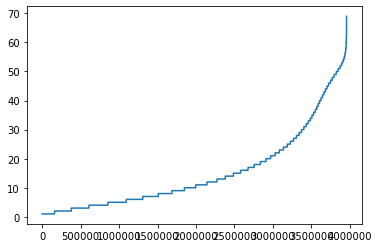

3401248
['생크림이', '좀더', '듬뿍', '올라가고', ',', '시트가', '더', '부드러우면', '더', '맛있을거같', '우유향이', '나고', '부드러운', '생크림', '신선하고', '새콤달콤한', '딸기', '드립커피도', '꽤', '괜찮은', '편', '양에', '비해', '비싸지만', '만족스러운', '딸기케이크']
['굿굿', '!', '']
['맛있어요']
['맛있어요']
['진짜', '유명해서', '한번', '먹어봄', '생딸기가', '아니고', '절임딸기', '한조각', '6300원', '시트도', '퍼석하고', '크림은', '그냥그럼', '이게', '맛있다는', '분들은', '생딸기를', '안드셔보셨', '생딸기를', '너무', '많이', '먹어서', '질려서', '맛있으신듯', '내', '돈', '내', '시간', '']
[[2825 1266 1318    3   15   15  583  585 1560  708  843  271  357  360
  2207   84  563 1476 2222    0    0    0    0    0    0    0    0    0
     0    0]
 [ 373    2    1    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [   5    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [   5    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0 

In [4]:
df = pd.read_csv("./data/review_data/total_review.csv", encoding="utf-8-sig", index_col=0)
review_df = df.dropna(axis=0)

# 컬럼 재배치
# review_df = review_df[["review","score"]]

# clean_str 함수를 통해서 X데이터를 정제해주어야함.
train_test_X = [clean_str(sentence) for sentence in review_df["review"]]
# 문장을 띄어쓰기 단위로 단어 분리
sentences = [sentence.split(' ') for sentence in train_test_X]
for i in range(5):
    print(sentences[i])

# 문장의 길이를 그래프화
sentence_len = [len(sentence) for sentence in sentences]
sentence_len.sort()
plt.plot(sentence_len)
plt.show()

# 총 3956974행의 데이터 중 30문장이내의 데이터는 3401248으로 85.9%에 육박.
# 따라서, padding의 기준을 30로 잡겠음.
print(sum([int(l<=30) for l in sentence_len]))
    
sentence_new = []
for sentence in sentences:
    sentence_new.append([word[:5] for word in sentence][:30])

sentences = sentence_new

for i in range(5):
    print(sentences[i])

# 학습데이터 / 테스트데이터 / 검증데이터 나누기
# train_X, test_X, train_y, test_y = train_test_split(setence, review_df["score"], test_size=0.3, random_state=1)
# print(train_X.shape, test_X.shape, train_y.shape, test_y.shape)    

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=3000)
tokenizer.fit_on_texts(sentences)
train_X = tokenizer.texts_to_sequences(sentences)
train_X = pad_sequences(train_X, padding='post')

print(train_X[:5])

In [5]:
train_y = np.array(review_df.iloc[:,0])

train_X, test_X, train_y, test_y = train_test_split(train_X, train_y, test_size=0.3, random_state=1)
print(train_X.shape, test_X.shape, train_y.shape, test_y.shape)    

print(train_y[:5])
print(type(train_y))
tmp_y = []
tmp_test_y = []

for data in train_y:
    tmp_y.append([data])
    
for data2 in test_y:
    tmp_test_y.append([data2])    

train_y = np.array(tmp_y)
test_y = np.array(tmp_test_y)
# a = np.array(tmp_y)
print(train_y.shape)
print(test_y.shape)
# print(a.shape)

(2769881, 30) (1187093, 30) (2769881,) (1187093,)
[4 4 1 1 4]
<class 'numpy.ndarray'>
(2769881, 1)
(1187093, 1)


In [6]:
check_path = './data/model_checkpoint/check_220108.ckpt'
checkpoint = ModelCheckpoint(filepath=check_path,save_best_only=True,
                             monitor='val_loss',verbose=1)

model = lstm_model(vocab_size = 30000, embedding_dim = 500, input_length = 30)

history = model.fit(train_X, train_y, epochs=15, batch_size=150, validation_split=0.3, callbacks=[checkpoint])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 30, 500)           15000000  
_________________________________________________________________
bidirectional (Bidirectional (None, 30, 128)           289280    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               98816     
_________________________________________________________________
dense (Dense)                (None, 32)                4128      
_________________________________________________________________
dense_1 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 102       
Total params: 15,392,854
Trainable params: 15,392,854
Non-trainable params: 0
____________________________________________

In [7]:
model.evaluate(test_X, test_y, verbose=0)

[0.12863808870315552, 0.9481304287910461]

In [10]:
test_sentence = """
텐동에 꽂혀서 텐동집들을 순회하던 도중 강남에 고쿠텐을 가게 됐습니다 적당히 맛있습니다 라는 표현이 적절한 곳입니다. 일단 첫맛은 튀김이다 보니 당연히 맛있지만 나중에 갈수록 튀김의 기름기 때문인지 아님 이집 특유의 담백함 때문인지 물리는 경우가 좀 있습니다

그래도 튀김이 맛없으면 안되죠 맛있습니다
장어텐동만 두번정도 먹어봤는데
뼈튀김 부터 시작해서 장어 오징어 새우 등등 먹어보면서 바삭함은 지속되고 좋았습니다
다만 아쉬운것은 간장맛이 잘 안느껴진다는것? 간장과 튀김의 조화가 살짝 아쉬운정도 입니다
그래도 강남에서 돌아다니다가 텐동이 먹고 싶다 하면 바로 이집으로 냉큼 달려올만한 가치가 있는 집입니다
"""
test_sentence = test_sentence.split(' ')
test_sentences = []
now_sentence = []
for word in test_sentence:
    now_sentence.append(word)
    test_sentences.append(now_sentence[:])
    
test_X_1 = tokenizer.texts_to_sequences(test_sentences)
test_X_1 = pad_sequences(test_X_1, padding='post', maxlen=30)
prediction = model.predict(test_X_1)
for idx, sentence in enumerate(test_sentences):
    print(sentence)
    print((prediction[idx]).round(3))
    
    
# model.save("./data/model/model_220106.h5")

['\n텐동에']
[0.    0.096 0.042 0.164 0.196 0.502]
['\n텐동에', '꽂혀서']
[0.    0.096 0.042 0.164 0.196 0.502]
['\n텐동에', '꽂혀서', '텐동집들을']
[0.    0.096 0.042 0.164 0.196 0.502]
['\n텐동에', '꽂혀서', '텐동집들을', '순회하던']
[0.    0.096 0.042 0.164 0.196 0.502]
['\n텐동에', '꽂혀서', '텐동집들을', '순회하던', '도중']
[0.    0.096 0.042 0.164 0.196 0.502]
['\n텐동에', '꽂혀서', '텐동집들을', '순회하던', '도중', '강남에']
[0.    0.096 0.042 0.164 0.196 0.502]
['\n텐동에', '꽂혀서', '텐동집들을', '순회하던', '도중', '강남에', '고쿠텐을']
[0.    0.096 0.042 0.164 0.196 0.502]
['\n텐동에', '꽂혀서', '텐동집들을', '순회하던', '도중', '강남에', '고쿠텐을', '가게']
[0.    0.007 0.    0.004 0.831 0.158]
['\n텐동에', '꽂혀서', '텐동집들을', '순회하던', '도중', '강남에', '고쿠텐을', '가게', '됐습니다']
[0.    0.007 0.    0.004 0.831 0.158]
['\n텐동에', '꽂혀서', '텐동집들을', '순회하던', '도중', '강남에', '고쿠텐을', '가게', '됐습니다', '적당히']
[0.    0.    0.    0.085 0.915 0.   ]
['\n텐동에', '꽂혀서', '텐동집들을', '순회하던', '도중', '강남에', '고쿠텐을', '가게', '됐습니다', '적당히', '맛있습니다']
[0.    0.    0.    0.001 0.996 0.003]
['\n텐동에', '꽂혀서', '텐동집들을', '순회하던', '도중', '강남에', '고쿠텐을', '가게', '

In [9]:
model.save("./data/model/model_lstm_220110.h5")